In this notebook we will apply the XGBoost algoritm to model the expected criminality levels when a certain event did not occur. In Chicago there is an annual festival during which many thefts happen. The question is how many (arrests for) theft can be attributed to this festival.

Theft numbers are treated as time series. The dates of the festival are removed from the data, using surrounding points, we model the number of thefts that are expected to happen when the event never took place. If a model is trained on data in which the festival dates are not present, it will not learn anything about this festival. The model is then applied to the festival dates.

In (Wang, 2022)* the authors describe a method of timeseries forecasting using XGBoost. They do this by turning forecasting into a supervised learning problem. Given a timeseries $X_t$, one can regress $X_t$ as a function of its previous values:

$$X_t = f(X_{t-1},\dots, X_{t-h})$$

where $f$ is a function made of boosted trees. The idea behind this notebook is to extend this idea to predicting values between two datapoints:

$$X_t = f(X_{t-h_1},\dots, X_{t+h_2})$$

Or in this special case where the festival lasts multiple days, we want to impute multiple values of the time series. Let $T={\tau_a,\dots,\tau_b}$ be the indices time series points of multiple days: we compute for $\tau_0\in T$ the number of thefts according to

$$X_{\tau_0} = f(X_{\tau_a-h_1},\dots, X_{\tau_a-1}, \dots X_{\tau_b+1},\dots, X_{\tau_b+h_2})$$

Without too many specific details we continue with the analysis.

* https://ieeexplore.ieee.org/abstract/document/9058617

Note that the goal of this small project is *not* to find the best model, it about showcasing an interpolation method using XGBoost. Therefore we will not be performing hyperparameter tuning and use the default parameters of the model.

In [ ]:
from Chicagodata import Chicago

import pandas as pd
import numpy as np
import seaborn as sns

Some EDA:

In [ ]:
data_agg = data.data_predict
data_agg = data_agg[(41.855 <= data_agg["Latitude"]) & (data_agg["Latitude"] <= 41.885)]
data_agg = data_agg[(-87.705 <= data_agg["Longitude"]) & (data_agg["Longitude"] <= -87.615)]
data_agg = data_agg[data_agg["Date"].dt.year >= 2019]

Filling a series of 7 days, ranging from 1st to 7th of august 2019 
For interpolation, we use a whole week before and after the masked dates. Because the festival returns annually, the theftdata needs to be removed for each year. Otherwise the model picks up the pattern and imposes it on the 2019 data which we are interested in. This is done automatically in the Chicago class.

In [2]:
fill_days = 7
with_number = 7
first_date_interval = pd.to_datetime('8-1-2019')

Loading the crime data from Chicago

In [4]:
data = Chicago()

Computing data_predict
Computing data_train
Training model
Computing prediction


Let's plot the numbers of criminality data

In [5]:
df = data.data
df = df[(41.855 <= df["Latitude"]) & (df["Latitude"] <= 41.885)]
df = df[(-87.705 <= df["Longitude"]) & (df["Longitude"] <= -87.615)]



The model is trained. Removing the right dates, turning the timeseries imputation into a supervised learning problem is all done within the Chicago class. For further details, see the script Chicagodata.py.

In [6]:
data.fit_predict_xgb_model(first_date_interval, fill_days, with_number)

Computing data_predict
Computing data_train
Training model
Computing prediction


The blue points are observed numbers of thefts and the red points are predictions/imputations of the XGBoost model. Note that the blue points are much more dispersed than the red points. This is because the blue points are realisations of a Poisson random variable, whereas the XGBoost model predicts *means* of a Poisson variable. 

The bottom left plot is where the festival takes place, as seen by the blue dots shooting out of the rest.

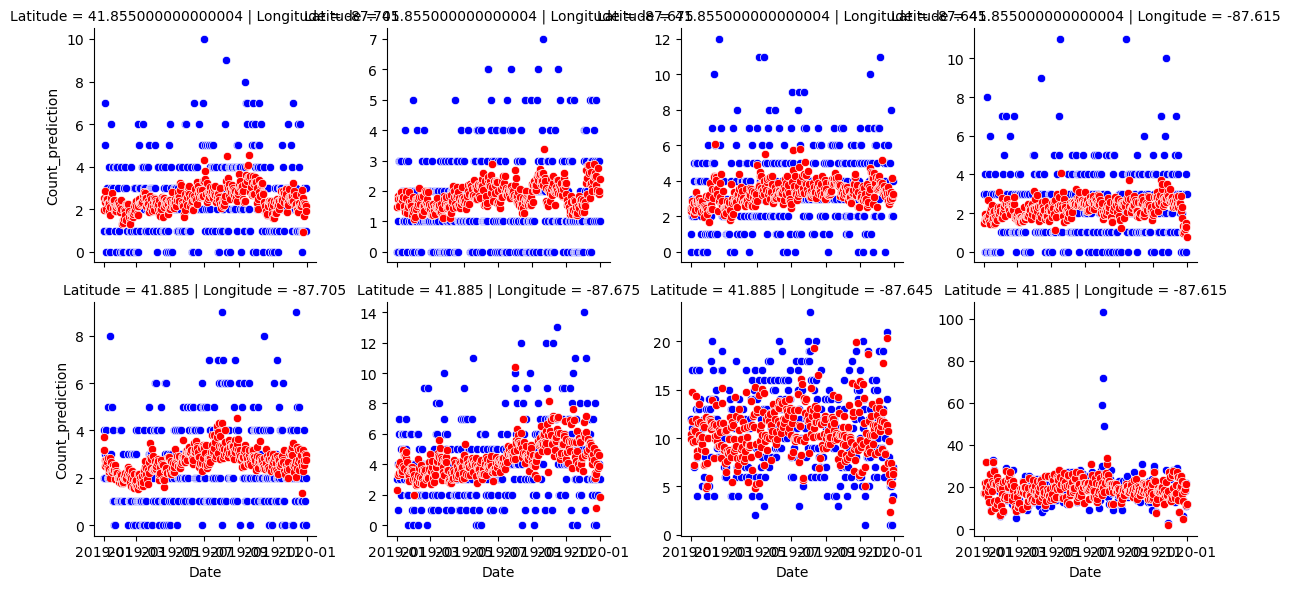

In [7]:
data_agg = data.data_predict
data_agg = data_agg[(41.855 <= data_agg["Latitude"]) & (data_agg["Latitude"] <= 41.885)]
data_agg = data_agg[(-87.705 <= data_agg["Longitude"]) & (data_agg["Longitude"] <= -87.615)]
data_agg = data_agg[data_agg["Date"].dt.year >= 2019]

g = sns.FacetGrid(data_agg, col='Longitude', row='Latitude', sharey=False)
g.map(sns.scatterplot, "Date", "Count", color="b")
g.map(sns.scatterplot, "Date", "Count_prediction", color="r")

In [21]:
startdate = pd.to_datetime('8-1-2019')
dates = pd.date_range(start=startdate, end=startdate+pd.DateOffset(days=3))

data_festival = data_agg[data_agg["Date"].isin(dates)]
idx_location = (data_festival["Latitude"]==41.885) & (data_festival["Longitude"]==-87.615)
data_festival = data_festival[idx_location]

np.sum(data_festival["Count"] - data_festival["Count_prediction"])

209.56675910949707

From here, we conclude that about 210 theft arrests are attributable to the festival.